In [1]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import os
os.chdir(project_root)

In [2]:
import torch
import numpy as np
import yaml
from torch.utils.data import DataLoader

from src.data.pipeline import get_datasets
from src.models.transformer_model import StockTransformer
from src.simulation.engine import BacktestEngine
from src.simulation.metrics import compute_metrics
from src.utils.config import load_config

In [3]:
config = load_config()

# Use same project root as load_config() so path works regardless of cwd
from src.utils import config as _cfg
config_path = _cfg.PROJECT_ROOT / "configs" / "default_config.yaml"
with config_path.open("r", encoding="utf-8") as f:
    raw_cfg = yaml.safe_load(f)
sim = raw_cfg.get("simulation", {})

initial_capital = float(sim.get("initial_capital", 100_000))
position_size_pct = float(sim.get("position_size_pct", 1.0))
entry_threshold_pct = float(sim.get("entry_threshold_pct", 0.5))
exit_threshold_pct = float(sim.get("exit_threshold_pct", -0.5))
commission_pct = float(sim.get("commission_pct", 0.1))
risk_free_rate_annual = float(sim.get("risk_free_rate_annual", 0.03))

print("Simulation config:", initial_capital, position_size_pct, entry_threshold_pct, exit_threshold_pct, commission_pct)

Simulation config: 100000.0 1.0 0.5 -0.5 0.1


In [4]:
_, _, test_dataset, feature_columns = get_datasets(config)
print(f"Test samples: {len(test_dataset)}, features: {len(feature_columns)}")

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)
Test samples: 1427, features: 34


In [5]:
# Use project root + config checkpoint filename (set paths.checkpoint_file in config for correct model)
checkpoint_name = getattr(config.paths, "checkpoint_file", "best_model.pt")
checkpoint_path = _cfg.PROJECT_ROOT / config.paths.models_dir / checkpoint_name
if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}. Train with 03_train_model.ipynb or set paths.checkpoint_file in config.")
import time
mtime = time.ctime(checkpoint_path.stat().st_mtime)
checkpoint = torch.load(checkpoint_path, map_location="cpu")
state_dict = checkpoint["model_state_dict"]
print(f"Loaded: {checkpoint_path.name} (modified {mtime})")
print(f"Checkpoint: epoch {checkpoint.get('epoch', '?') + 1}, val loss {checkpoint.get('score', '?'):.6f}")

input_dim_checkpoint = state_dict["input_projection.weight"].shape[1]
input_dim_current = len(feature_columns)
d_model = state_dict["input_projection.weight"].shape[0]
n_layers = len([k for k in state_dict if "encoder.layers" in k and "self_attention.w_q.weight" in k])
n_heads = config.model.n_heads
d_ff = state_dict["encoder.layers.0.feed_forward.linear1.weight"].shape[0]

if input_dim_checkpoint != input_dim_current:
    model = StockTransformer(
        input_dim=input_dim_current,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    model_dict = model.state_dict()
    compatible_dict = {k: v for k, v in state_dict.items()
                      if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict, strict=False)
    print(f"Loaded {len(compatible_dict)}/{len(state_dict)} params (input_dim mismatch: using current features)")
else:
    model = StockTransformer(
        input_dim=input_dim_checkpoint,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    model.load_state_dict(state_dict)
    print("Model loaded.")
model.eval()

Loaded: best_model.pt (modified Thu Feb  5 14:04:36 2026)
Checkpoint: epoch 30, val loss 0.014834
Model loaded.


StockTransformer(
  (input_projection): Linear(in_features=34, out_features=128, bias=True)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attention): MultiHeadAttention(
          (w_q): Linear(in_features=128, out_features=128, bias=True)
          (w_k): Linear(in_features=128, out_features=128, bias=True)
          (w_v): Linear(in_features=128, out_features=128, bias=True)
          (w_o): Linear(in_features=128, out_features=128, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.

In [13]:
test_loader = DataLoader(
    test_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
)

all_predictions = []
all_targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        pred = model(batch_x)
        if pred.dim() == 1:
            pred = pred.unsqueeze(1)
        if batch_y.dim() == 1:
            batch_y = batch_y.unsqueeze(1)
        all_predictions.append(pred)
        all_targets.append(batch_y)

predictions = torch.cat(all_predictions, dim=0).numpy().flatten()
targets = torch.cat(all_targets, dim=0).numpy().flatten()

prices = targets[:-1]
pred_next = predictions[1:]
print(f"Backtest length: {len(prices)} days")

# Why 0 trades? We only BUY when pred_next >= price * (1 + entry_threshold_pct/100)
entry_bound = prices * (1 + entry_threshold_pct / 100.0)
buy_ok = pred_next >= entry_bound
pct_days_buy = 100 * np.sum(buy_ok) / len(prices)
pred_pct = 100 * (pred_next - prices) / np.where(prices == 0, np.nan, prices)
pred_pct = np.nan_to_num(pred_pct, nan=0.0)
print(f"Entry threshold: pred >= current + {entry_threshold_pct}%")
print(f"Days where buy condition met: {np.sum(buy_ok)} / {len(prices)} ({pct_days_buy:.1f}%)")
print(f"Pred vs price: mean {np.mean(pred_pct):.3f}%, min {np.min(pred_pct):.3f}%, max {np.max(pred_pct):.3f}%")

# Simulate first few days to see what happens
import importlib
from src.simulation import rules
importlib.reload(rules)  # Force reload to get updated function
from src.simulation.rules import signal_from_prediction
print(f"\nFirst 5 days simulation:")
in_pos = False
for i in range(min(5, len(prices))):
    sig = signal_from_prediction(prices[i], pred_next[i], in_pos, entry_threshold_pct, exit_threshold_pct)
    print(f"  Day {i}: price={prices[i]:.4f}, pred={pred_next[i]:.4f}, in_pos={in_pos}, signal={sig}")
    if sig == "buy" and not in_pos:
        in_pos = True
    elif sig == "sell" and in_pos:
        in_pos = False

# Reload engine module too so it uses updated rules
from src.simulation import engine, rules
importlib.reload(rules)
importlib.reload(engine)
from src.simulation.engine import BacktestEngine

engine = BacktestEngine(
    initial_capital=initial_capital,
    position_size_pct=position_size_pct,
    entry_threshold_pct=entry_threshold_pct,
    exit_threshold_pct=exit_threshold_pct,
    commission_pct=commission_pct,
)

result = engine.run(prices=prices, predictions=pred_next)

metrics = compute_metrics(
    result,
    initial_capital=initial_capital,
    risk_free_rate_annual=risk_free_rate_annual,
    prices=prices,
)

print("=" * 50)
print("BACKTEST METRICS")
print("=" * 50)
print(f"Total return:        {metrics.total_return_pct:.2f}%")
print(f"Sharpe (annual):     {metrics.sharpe_ratio_annual:.3f}")
print(f"Max drawdown:        {metrics.max_drawdown_pct:.2f}%")
print(f"Number of trades:    {metrics.num_trades}")
if metrics.buy_and_hold_return_pct is not None:
    print(f"Buy & hold return:   {metrics.buy_and_hold_return_pct:.2f}%")
if metrics.excess_return_vs_bh_pct is not None:
    print(f"Excess vs B&H:       {metrics.excess_return_vs_bh_pct:+.2f}%")
print("=" * 50)

Backtest length: 1426 days
Entry threshold: pred >= current + 0.5%
Days where buy condition met: 1424 / 1426 (99.9%)
Pred vs price: mean -8.062%, min -31.362%, max 0.605%

First 5 days simulation:
  Day 0: price=-0.7938, pred=-0.7035, in_pos=False, signal=buy
  Day 1: price=-0.7933, pred=-0.7036, in_pos=True, signal=hold
  Day 2: price=-0.7929, pred=-0.7058, in_pos=True, signal=hold
  Day 3: price=-0.7919, pred=-0.7071, in_pos=True, signal=hold
  Day 4: price=-0.7920, pred=-0.7068, in_pos=True, signal=hold


ImportError: module src.simulation.rules not in sys.modules

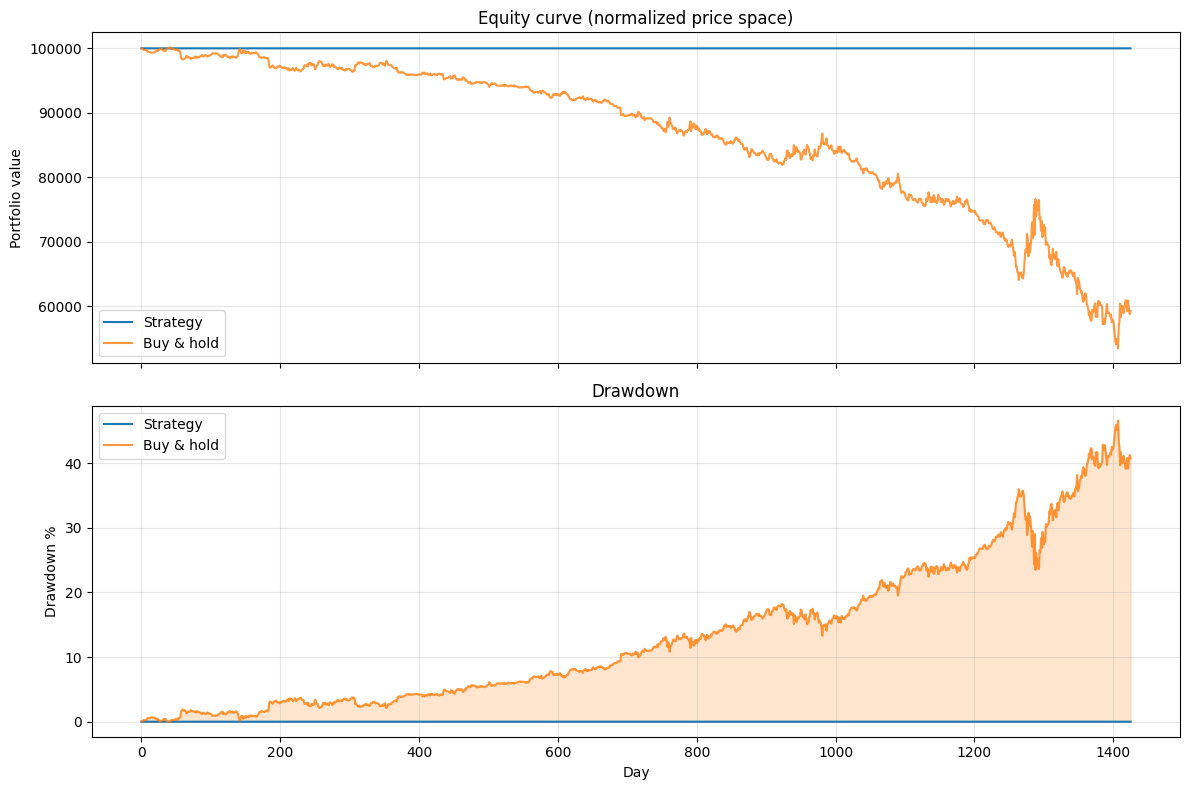

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1 = axes[0]
ax1.plot(result.equity_curve, label="Strategy")
bh_value = initial_capital * (prices / prices[0])
ax1.plot(bh_value, label="Buy & hold", alpha=0.8)
ax1.set_ylabel("Portfolio value")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title("Equity curve (normalized price space)")

ax2 = axes[1]
x = np.arange(len(result.equity_curve))
peak = np.maximum.accumulate(result.equity_curve)
safe_peak = np.where(peak <= 0, np.nan, peak)
dd = 100 * (peak - result.equity_curve) / safe_peak
dd = np.nan_to_num(dd, nan=0.0)
ax2.plot(x, dd, label="Strategy", color="C0")
ax2.fill_between(x, dd, 0, alpha=0.3, color="C0")
bh_value_dd = initial_capital * (prices / prices[0])
peak_bh = np.maximum.accumulate(bh_value_dd)
safe_peak_bh = np.where(peak_bh <= 0, np.nan, peak_bh)
dd_bh = 100 * (peak_bh - bh_value_dd) / safe_peak_bh
dd_bh = np.nan_to_num(dd_bh, nan=0.0)
ax2.plot(x, dd_bh, label="Buy & hold", color="C1", alpha=0.8)
ax2.fill_between(x, dd_bh, 0, alpha=0.2, color="C1")
ax2.set_ylabel("Drawdown %")
ax2.set_xlabel("Day")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_title("Drawdown")

plt.tight_layout()
plt.show()